##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for beginners

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

This tutorial is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. To run all the code in the notebook, select **Runtime** > **Run all**. To run the code cells one at a time, hover over each cell and select the **Run cell** icon.

![Run cell icon](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/images/beginner/run_cell_icon.png?raw=1)

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


If you are following along in your own development environment, rather than [Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb), see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment. See the [install guide](https://www.tensorflow.org/install) for details.

## Load a dataset

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The pixel values of the images range from 0 through 255. Scale these values to a range of 0 to 1 by dividing the values by `255.0`. This also converts the sample data from integers to floating-point numbers:

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


## Build a machine learning model

Build a `tf.keras.Sequential` model:

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

[`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) is useful for stacking layers where each layer has one input [tensor](https://www.tensorflow.org/guide/tensor) and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [4]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.47640672,  0.73249143,  0.5038897 ,  0.46472815, -0.20138466,
        -0.28474084,  0.02428399, -0.12903199,  0.3040612 , -0.1339834 ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class: 

In [5]:
tf.nn.softmax(predictions).numpy()

array([[0.12738982, 0.16457008, 0.13093942, 0.12591074, 0.06468054,
        0.05950761, 0.08105509, 0.06953381, 0.10722251, 0.06919037]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [9]:
loss_fn(y_train[:1], predictions).numpy()

2.821651

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [11]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2964 - accuracy: 0.9136
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1426 - accuracy: 0.9575
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1072 - accuracy: 0.9679
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0875 - accuracy: 0.9732
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0738 - accuracy: 0.9764


The `Model.evaluate` method checks the model's performance, usually on a [validation set](https://developers.google.com/machine-learning/glossary#validation-set) or [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [12]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0727 - accuracy: 0.9771 - 590ms/epoch - 2ms/step


[0.07266710698604584, 0.9771000146865845]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [13]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [14]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[5.12275790e-07, 1.52998556e-08, 1.76457615e-05, 1.72587504e-04,
        3.77269396e-11, 1.77291793e-06, 2.53081948e-11, 9.99790132e-01,
        5.57604562e-06, 1.18805756e-05],
       [1.55075679e-06, 1.21192003e-04, 9.99830842e-01, 7.22004643e-06,
        1.73543536e-12, 1.81285225e-06, 5.79055950e-06, 1.98660546e-10,
        3.14878162e-05, 6.45466753e-12],
       [3.93013522e-07, 9.98167992e-01, 2.39686779e-04, 1.75767545e-05,
        5.84704503e-05, 3.55437737e-06, 6.65296175e-05, 1.14710897e-03,
        2.97388062e-04, 1.31714569e-06],
       [9.99045312e-01, 1.89995841e-09, 2.61542096e-04, 8.36971412e-06,
        1.60071852e-06, 6.53137658e-06, 6.70085021e-04, 2.55202963e-06,
        5.24578354e-07, 3.41585928e-06],
       [5.32290869e-06, 6.25319219e-09, 6.64079053e-05, 2.14720345e-07,
        9.95099843e-01, 7.90015633e-07, 1.62506083e-04, 1.06379026e-04,
        4.82659152e-06, 4.55373107e-03]], dtype=float32)>

## Conclusion

Congratulations! You have trained a machine learning model using a prebuilt dataset using the [Keras](https://www.tensorflow.org/guide/keras/overview) API.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/). To learn more about building models with Keras, read the [guides](https://www.tensorflow.org/guide/keras). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).


In [15]:
!pip install remotezip tqdm opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7949 sha256=8c6ac0936bb5cbf72cd8aa02b2e95a3f25171d42ab9955325a36a74de955967e
  Stored in directory: /root/.cache/pip/wheels/60/74/6c/b12b4c8fb4b7ab08f495ce17e88f1e98835268af7a8ad5588f
Successfully built remotezip


In [16]:
pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [18]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [19]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

def list_files_from_zip_url(zip_url):
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [20]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [21]:
def get_class(fname):
  return fname.split('_')[1]

In [22]:
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [23]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [24]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [25]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [26]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]
  return files_subset

In [27]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [29]:
def download_from_zip(zip_url, to_dir, file_names):
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn 
      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [30]:
def split_class_lists(files_for_class, count):
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [35]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs


In [36]:
download_dir = pathlib.Path('./subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 10, "val": 5, "test": 5},
                                       download_dir = download_dir)

train :


100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


val :


100%|██████████| 50/50 [00:05<00:00,  9.78it/s]


test :


100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


# Frames

In [37]:
def format_frames(frame, output_size):
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)

  return frame

In [38]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
  result = []
  src = cv2.VideoCapture(str(video_path))
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)
  
  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2,1,0]]
  return result

In [40]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  26.6M      0  0:00:02  0:00:02 --:--:-- 26.6M


In [42]:
video_path = "End_of_a_jam.ogv"
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(9, 224, 224, 3)

In [43]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


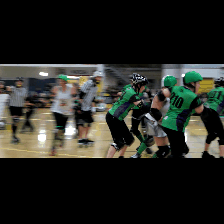

In [44]:
to_gif(sample_video)


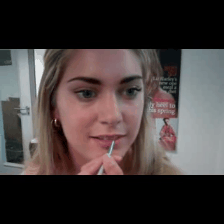

In [45]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

In [ ]:
class FrameGenerator:
  def __init__(sel, path, n_frames,)